Setup of code:

- Generate timeseries for a coupled oscillator system, with adjustable coupling
- Compute the R, S and TSE components
- Normalize the R and S values so that they can be mapped onto the TSE heatmap
- Map the trajectories for a variety of coupling factors.

Expectation:
If the system does not exhibit synergistic interactions, then trajectory will just be a straight line accross the redundancy axis, from 0 to max with decreasing TSE. The coupling factor is then proportional to the speed of the trajectory. However, we want to visualise a trajectory that includes synergistic interactions.

Solution/checkup:
Check if the coupled oscillator system exhibits synergy.

In [1]:
# LIBRARIES
import pandas as pd
from sklearn.utils import Bunch
import infotopo
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# FUNCTIONS
# Function for Simulating Lotka-Volterra with Resource and different interaction cases
def simulate_system_with_resource(interaction_type):
    P = np.zeros_like(t)
    H = np.zeros_like(t)
    R = np.zeros_like(t)
    
    # Set initial conditions
    P[0] = initial_P
    H[0] = initial_H
    R[0] = initial_R
    
    # Iterate over time steps
    for i in range(1, len(t)):
        if interaction_type == "synergistic":
            # Synergistic interaction case
            prey_growth = alpha * P[i-1] * R[i-1] - beta * P[i-1] * H[i-1]
            predation = delta * P[i-1] * H[i-1] - gamma * H[i-1]
            resource_growth = mu * R[i-1] * (1 - R[i-1] / K) - lambda_ * P[i-1] * R[i-1]
        elif interaction_type == "redundant":
            # Redundant interaction case
            prey_growth = alpha * P[i-1] * R[i-1] - beta * P[i-1] * H[i-1] * 0.1  # minimal predator effect
            predation = delta * P[i-1] * H[i-1] * 0.1 - gamma * H[i-1]  # minimal predator impact
            resource_growth = mu * R[i-1] * (1 - R[i-1] / K) - lambda_ * P[i-1] * R[i-1] * 0.1  # weak impact on resource
        elif interaction_type == "mixed":
            # Mixed interaction case (both synergistic and redundant)
            prey_growth = alpha * P[i-1] * R[i-1] - beta * P[i-1] * H[i-1] * 0.5  # some redundancy
            predation = delta * P[i-1] * H[i-1] - gamma * H[i-1] * 0.5  # some synergy
            resource_growth = mu * R[i-1] * (1 - R[i-1] / K) - lambda_ * P[i-1] * R[i-1] * 0.5  # mixed impact on resource
            
        # Update populations
        P[i] = P[i-1] + prey_growth * dt
        H[i] = H[i-1] + predation * dt
        R[i] = R[i-1] + resource_growth * dt
        
        # Avoid negative populations and resources
        P[i] = max(P[i], 0)
        H[i] = max(H[i], 0)
        R[i] = max(R[i], 0)
    
    return P, H, R

# Convert a given pandas dataframe to a Bunch object
def dataframe_to_bunch(dataframe, target=None, feature_names=None, target_names=None, descr="Custom dataset"):
    if feature_names is None:
        feature_names = dataframe.columns.tolist()
    
    return Bunch(
        data=dataframe.to_numpy(),
        target=target if target is not None else np.zeros(dataframe.shape[0]),
        feature_names=feature_names,
        target_names=target_names if target_names is not None else ["target"],
        DESCR=descr
    )

# Function to obtain the metrics from the infotopo module
def obtain_infotopo_metrics(dataset):
    
    dimension_max = dataset.shape[1]
    dimension_tot = dataset.shape[1]
    sample_size = dataset.shape[0]
    nb_of_values = 16
    forward_computation_mode = False
    work_on_transpose = False
    supervised_mode = False
    sampling_mode = 1
    deformed_probability_mode = False

    information_topo = infotopo.infotopo(dimension_max = dimension_max,
                                dimension_tot = dimension_tot,
                                sample_size = sample_size,
                                work_on_transpose = work_on_transpose,
                                nb_of_values = nb_of_values,
                                sampling_mode = sampling_mode,
                                deformed_probability_mode = deformed_probability_mode,
                                supervised_mode = supervised_mode,
                                forward_computation_mode = forward_computation_mode)
    
    Nentropie = information_topo.simplicial_entropies_decomposition(dataset) # Make sure the datatype is a Bunch object
    Ninfomut = information_topo.simplicial_infomut_decomposition(Nentropie)
    #Nfree_energy = information_topo.total_correlation_simplicial_lanscape(Nentropie)
    
    return  Nentropie, Ninfomut

# Function to compute TSE complexity
def compute_tse_complexity(TC_dict):
    """Compute TSE complexity efficiently."""
    N = max(len(subset) for subset in TC_dict)  # Maximum subset size
    TSE = 0
    for gamma in range(1, N):
        TC_full = (gamma / N) * TC_dict[tuple(range(1, N + 1))]
        E_TC_gamma = np.mean([TC_dict[subset] for subset in TC_dict if len(subset) == gamma])
        TSE += TC_full - E_TC_gamma
    return TSE

In [3]:
# Define parameters for the model
alpha = 0.1  # Prey growth rate
beta = 0.02  # Predator impact on prey
gamma = 0.1  # Predator death rate
delta = 0.01  # Predator growth rate due to predation
mu = 0.05  # Resource growth rate
lambda_ = 0.01  # Resource consumption rate by prey
K = 50  # Carrying capacity of the resource

# Time parameters
t_start = 0
t_end = 1000
dt = 0.1
t = np.arange(t_start, t_end, dt)

# Initial populations
initial_P = 40  # Initial prey population
initial_H = 9   # Initial predator population
initial_R = 50  # Initial resource amount

# Simulate three different interaction cases
P_synergistic, H_synergistic, R_synergistic = simulate_system_with_resource("synergistic")
P_redundant, H_redundant, R_redundant = simulate_system_with_resource("redundant")
P_mixed, H_mixed, R_mixed = simulate_system_with_resource("mixed")

# Saving the time series data to text files
np.savetxt("Data/synergistic_timeseries.txt", np.column_stack((t, P_synergistic, H_synergistic, R_synergistic)), header="Time Prey Predators Resource", comments="")
np.savetxt("Data/redundant_timeseries.txt", np.column_stack((t, P_redundant, H_redundant, R_redundant)), header="Time Prey Predators Resource", comments="")
np.savetxt("Data/mixed_timeseries.txt", np.column_stack((t, P_mixed, H_mixed, R_mixed)), header="Time Prey Predators Resource", comments="")

In [4]:
# Load the time series data from the text files
synergistic_data = np.loadtxt("Data/synergistic_timeseries.txt", delimiter=" ", skiprows=1)
redundant_data = np.loadtxt("Data/redundant_timeseries.txt", delimiter=" ", skiprows=1)
mixed_data = np.loadtxt("Data/mixed_timeseries.txt", delimiter=" ", skiprows=1)

# Extract the columns: Time, Prey, Predators, and Resource
t_loaded = synergistic_data[:, 0]  # Time
P_synergistic_loaded = synergistic_data[:, 1]  # Prey (Synergistic)
H_synergistic_loaded = synergistic_data[:, 2]  # Predators (Synergistic)
R_synergistic_loaded = synergistic_data[:, 3]  # Resource (Synergistic)

P_redundant_loaded = redundant_data[:, 1]  # Prey (Redundant)
H_redundant_loaded = redundant_data[:, 2]  # Predators (Redundant)
R_redundant_loaded = redundant_data[:, 3]  # Resource (Redundant)

P_mixed_loaded = mixed_data[:, 1]  # Prey (Mixed)
H_mixed_loaded = mixed_data[:, 2]  # Predators (Mixed)
R_mixed_loaded = mixed_data[:, 3]  # Resource (Mixed)

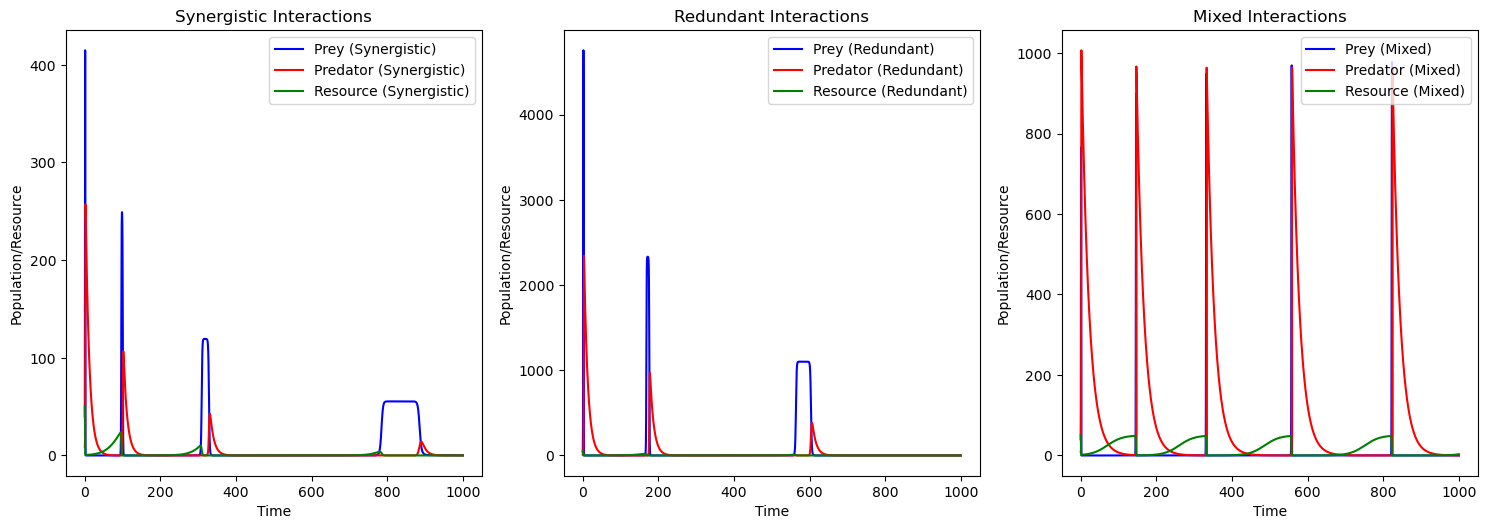

In [5]:
# Plotting the results
plt.figure(figsize=(15, 10))

# Synergistic case
plt.subplot(2, 3, 1)
plt.plot(t, P_synergistic, label="Prey (Synergistic)", color="b")
plt.plot(t, H_synergistic, label="Predator (Synergistic)", color="r")
plt.plot(t, R_synergistic, label="Resource (Synergistic)", color="g")
plt.title("Synergistic Interactions")
plt.xlabel("Time")
plt.ylabel("Population/Resource")
plt.legend()

# Redundant case
plt.subplot(2, 3, 2)
plt.plot(t, P_redundant, label="Prey (Redundant)", color="b")
plt.plot(t, H_redundant, label="Predator (Redundant)", color="r")
plt.plot(t, R_redundant, label="Resource (Redundant)", color="g")
plt.title("Redundant Interactions")
plt.xlabel("Time")
plt.ylabel("Population/Resource")
plt.legend()

# Mixed case
plt.subplot(2, 3, 3)
plt.plot(t, P_mixed, label="Prey (Mixed)", color="b")
plt.plot(t, H_mixed, label="Predator (Mixed)", color="r")
plt.plot(t, R_mixed, label="Resource (Mixed)", color="g")
plt.title("Mixed Interactions")
plt.xlabel("Time")
plt.ylabel("Population/Resource")
plt.legend()

plt.tight_layout()
plt.show()

# Generate oscillator dynamics

In [6]:
# Define parameters
dt = 0.01  # Time step
t_end = 200  # End time
time = np.arange(0, t_end, dt)  # Time array

# Initial conditions
theta1, theta2, theta3 = np.pi / 2, np.pi / 8, np.pi / 6  # Initial phases
omega1, omega2, omega3 = 1.0, 1.2, 0.8  # Natural frequencies
coupling_factor = 0.1  # Coupling strength

# Initialize arrays to store results
theta1_series = np.zeros_like(time)
theta2_series = np.zeros_like(time)
theta3_series = np.zeros_like(time)

# Set initial conditions
theta1_series[0], theta2_series[0], theta3_series[0] = theta1, theta2, theta3

# Simulate the coupled oscillator system
for i in range(1, len(time)):
    # Coupling terms
    coupling1 = coupling_factor * (np.sin(theta2_series[i-1] - theta1_series[i-1]) + np.sin(theta3_series[i-1] - theta1_series[i-1]))
    coupling2 = coupling_factor * (np.sin(theta1_series[i-1] - theta2_series[i-1]) + np.sin(theta3_series[i-1] - theta2_series[i-1]))
    coupling3 = coupling_factor * (np.sin(theta1_series[i-1] - theta3_series[i-1]) + np.sin(theta2_series[i-1] - theta3_series[i-1]))
    
    # Update phases using Euler's method
    theta1_series[i] = theta1_series[i-1] + (omega1 + coupling1) * dt
    theta2_series[i] = theta2_series[i-1] + (omega2 + coupling2) * dt
    theta3_series[i] = theta3_series[i-1] + (omega3 + coupling3) * dt

# Saving the time series data to text files
np.savetxt("Data/time_series_coupled_oscillator.txt", np.column_stack((theta1_series, theta2_series, theta3_series)), header="x1 x2 x3", comments="")

In [7]:
# Load the time series data from the text file into a pandas DataFrame
df_oscillators = pd.read_csv("Data/time_series_coupled_oscillator.txt", sep=r'\s+')

# Extract the columns as individual series (optional)
theta1_series = df_oscillators.iloc[:, 0]
theta2_series = df_oscillators.iloc[:, 1]
theta3_series = df_oscillators.iloc[:, 2]

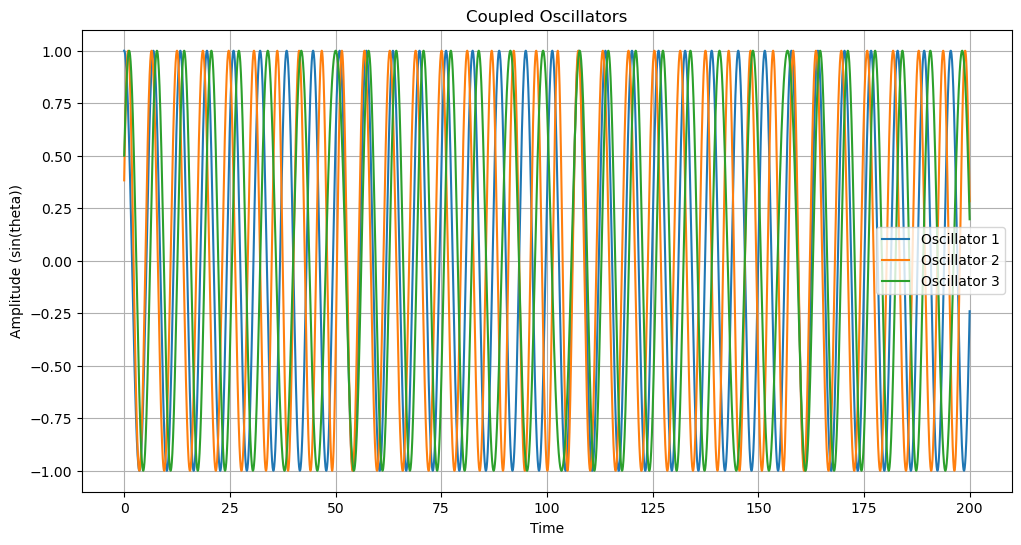

In [8]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(time, np.sin(theta1_series), label="Oscillator 1")
plt.plot(time, np.sin(theta2_series), label="Oscillator 2")
plt.plot(time, np.sin(theta3_series), label="Oscillator 3")
plt.title("Coupled Oscillators")
plt.xlabel("Time")
plt.ylabel("Amplitude (sin(theta))")
plt.legend()
plt.grid()
plt.show()

# Generate oscillator dynamics n>3

In [35]:
import numpy as np

def simulate_coupled_oscillators(num_oscillators, dt=0.01, t_end=200, initial_phases=None, natural_frequencies=None, coupling_factor=0.1, output_file="time_series_coupled_oscillator.txt"):
    """
    Simulates a system of coupled oscillators.

    Parameters:
        num_oscillators (int): Number of oscillators in the system.
        dt (float): Time step for the simulation.
        t_end (float): End time for the simulation.
        initial_phases (list or np.ndarray): Initial phases of the oscillators. If None, defaults to zeros.
        natural_frequencies (list or np.ndarray): Natural frequencies of the oscillators. If None, defaults to ones.
        coupling_factor (float): Coupling strength between oscillators.
        output_file (str): Path to save the time series data.

    Returns:
        np.ndarray: Time series of the oscillators' phases.
    """
    # Time array
    time = np.arange(0, t_end, dt)
    num_steps = len(time)

    # Initialize phases and frequencies
    if initial_phases is None:
        initial_phases = np.zeros(num_oscillators)
    if natural_frequencies is None:
        natural_frequencies = np.ones(num_oscillators)

    # Validate input lengths
    if len(initial_phases) != num_oscillators or len(natural_frequencies) != num_oscillators:
        raise ValueError("Length of initial_phases and natural_frequencies must match num_oscillators.")

    # Initialize arrays to store results
    theta_series = np.zeros((num_steps, num_oscillators))
    theta_series[0, :] = initial_phases

    # Simulate the coupled oscillator system
    for i in range(1, num_steps):
        for j in range(num_oscillators):
            # Compute coupling term for oscillator j
            coupling = sum(
                coupling_factor * np.sin(theta_series[i-1, k] - theta_series[i-1, j])
                for k in range(num_oscillators) if k != j
            )

            # Update phase using Euler's method
            theta_series[i, j] = theta_series[i-1, j] + (natural_frequencies[j] + coupling) * dt

    # Save the time series data to a text file
    header = " ".join([f"x{k+1}" for k in range(num_oscillators)])
    np.savetxt(output_file, theta_series, header=header, comments="")

    return theta_series

# Example usage
if __name__ == "__main__":
    num_oscillators = 4
    initial_phases = [np.pi / 2, np.pi / 8, np.pi / 6, np.pi / 3]
    natural_frequencies = [1.0, 1.2, 0.8, 0.3]
    coupling_factor = 0.1

    time_series = simulate_coupled_oscillators(
        num_oscillators=num_oscillators,
        dt=0.01,
        t_end=200,
        initial_phases=initial_phases,
        natural_frequencies=natural_frequencies,
        coupling_factor=coupling_factor
    )

In [36]:
# Load the time series data from the text file into a pandas DataFrame
df_oscillators = pd.read_csv("time_series_coupled_oscillator.txt", sep=r'\s+')

# Extract the columns as individual series (optional)
theta1_series = df_oscillators.iloc[:, 0]
theta2_series = df_oscillators.iloc[:, 1]
theta3_series = df_oscillators.iloc[:, 2]
theta4_series = df_oscillators.iloc[:, 3]

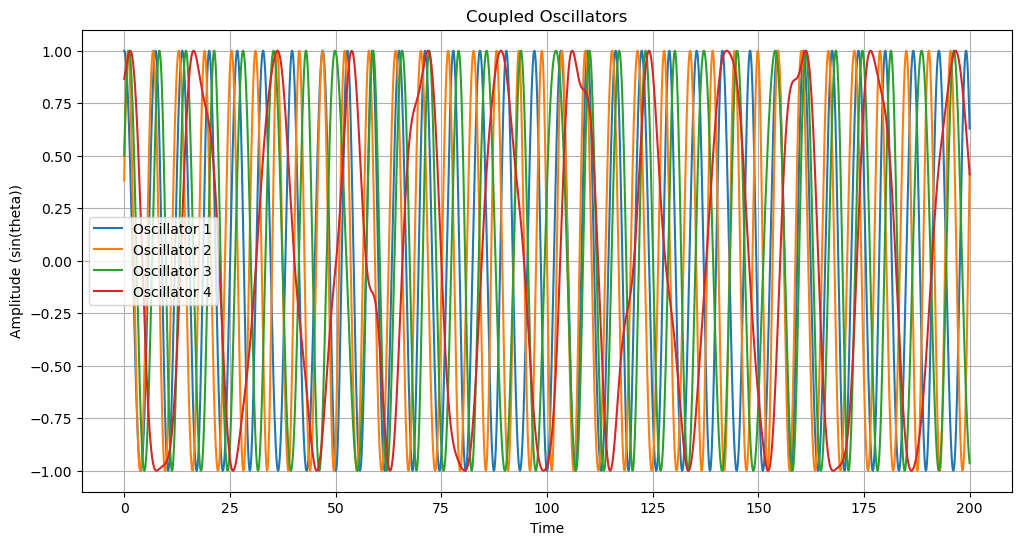

In [37]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(time, np.sin(theta1_series), label="Oscillator 1")
plt.plot(time, np.sin(theta2_series), label="Oscillator 2")
plt.plot(time, np.sin(theta3_series), label="Oscillator 3")
plt.plot(time, np.sin(theta4_series), label="Oscillator 4")
plt.title("Coupled Oscillators")
plt.xlabel("Time")
plt.ylabel("Amplitude (sin(theta))")
plt.legend()
plt.grid()
plt.show()

# Now analyse R, S and TSE for these cases
For each case, use a time sliding window to compute the evolution of R, S and TSE.
That is take a input a timeseries and a timestepsize and give a output a list of R, S and TSE values.

In [26]:
# Load the data from the text files into pandas DataFrames, excluding the 'Time' column

# Load Lotka-Volterra data
synergistic_df = pd.read_csv("Data/synergistic_timeseries.txt", delim_whitespace=True, usecols=[1, 2, 3])
redundant_df = pd.read_csv("Data/redundant_timeseries.txt", delim_whitespace=True, usecols=[1, 2, 3])
mixed_df = pd.read_csv("Data/mixed_timeseries.txt", delim_whitespace=True, usecols=[1, 2, 3])

# Load random number data
df_random = pd.read_csv("timeseries_test.txt", delim_whitespace=True)

# Load oscillator system
df_oscillators = pd.read_csv("time_series_coupled_oscillator.txt", delim_whitespace=True)

C:\Users\cyril\AppData\Local\Temp\ipykernel_2616\1962572664.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  synergistic_df = pd.read_csv("Data/synergistic_timeseries.txt", delim_whitespace=True, usecols=[1, 2, 3])
C:\Users\cyril\AppData\Local\Temp\ipykernel_2616\1962572664.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  redundant_df = pd.read_csv("Data/redundant_timeseries.txt", delim_whitespace=True, usecols=[1, 2, 3])
C:\Users\cyril\AppData\Local\Temp\ipykernel_2616\1962572664.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  mixed_df = pd.read_csv("Data/mixed_timeseries.txt", delim_whitespace=True, usecols=[1, 2, 3])
C:\Users\cyril\AppData\Local\Temp\ipykernel_2616\1962572664.py:9: Fu

In [27]:
def interactions_values(df_input):
    # Initialize an empty DataFrame
    columns = ['R_sum', 'S_sum', 'TSE_value']
    df_output = pd.DataFrame(columns=columns)

    # Set initial window conditions
    window_start = 0
    window_end = window_start + 100

    while window_end < len(df_input):
        bunch_data = dataframe_to_bunch(df_input.iloc[window_start:window_end])
        Nentropie, Ninfomut = obtain_infotopo_metrics(bunch_data.data)
        S_sum = sum(value for key, value in Ninfomut.items() if len(key) > 2 and value < 0)
        R_sum = sum(value for key, value in Ninfomut.items() if len(key) > 2 and value > 0)
        TSE_value = compute_tse_complexity(Ninfomut)

        # Add the new values to the dataframe
        new_row = pd.DataFrame({'R_sum': [R_sum], 'S_sum': [S_sum], 'TSE_value': [TSE_value]})
        df_output = pd.concat([df_output, new_row], ignore_index=True)
        
        window_start += 1
        window_end += 1

    # Normalize and absolutize all the values so that the S and R values are all positive and the maximum R and S are 1.
    #df_output.iloc[:, 1] = df_output.iloc[:, 1] * -1

    #max_R = df_output.iloc[:, 0].max()
    #max_S = df_output.iloc[:, 1].max()

    #if max_S > 0:
    #    df_output.iloc[:, 1] = df_output.iloc[:, 1] / max_S        
    #if max_R > 0:
    #    df_output.iloc[:, 0] = df_output.iloc[:, 0] / max_R

    return df_output

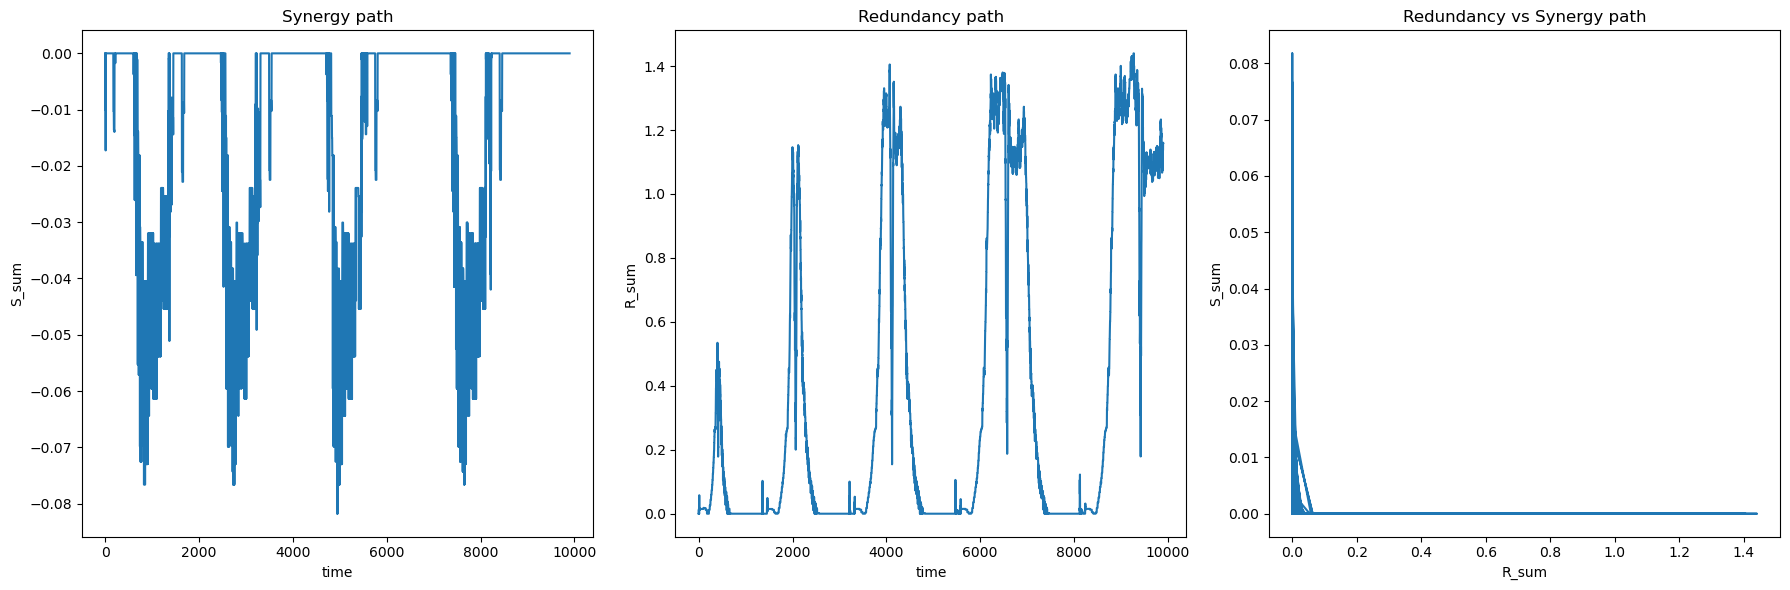

In [13]:
# Create a figure with 1 row and 3 columns for subplots
plt.figure(figsize=(18, 6))

# First subplot for Synergy path
plt.subplot(1, 3, 1)  # (rows, columns, index)
plt.plot(df.index, df['S_sum'])
plt.xlabel('time')
plt.ylabel('S_sum')
plt.title('Synergy path')

# Second subplot for Redundancy path
plt.subplot(1, 3, 2)
plt.plot(df.index, df['R_sum'])
plt.xlabel('time')
plt.ylabel('R_sum')
plt.title('Redundancy path')

# Third subplot for Redundancy vs Synergy path
plt.subplot(1, 3, 3)
plt.plot(df['R_sum'], -df['S_sum'])
plt.xlabel('R_sum')
plt.ylabel('S_sum')
plt.title('Redundancy vs Synergy path')

# Adjust layout to avoid overlap and display the plot
plt.tight_layout()
plt.show()

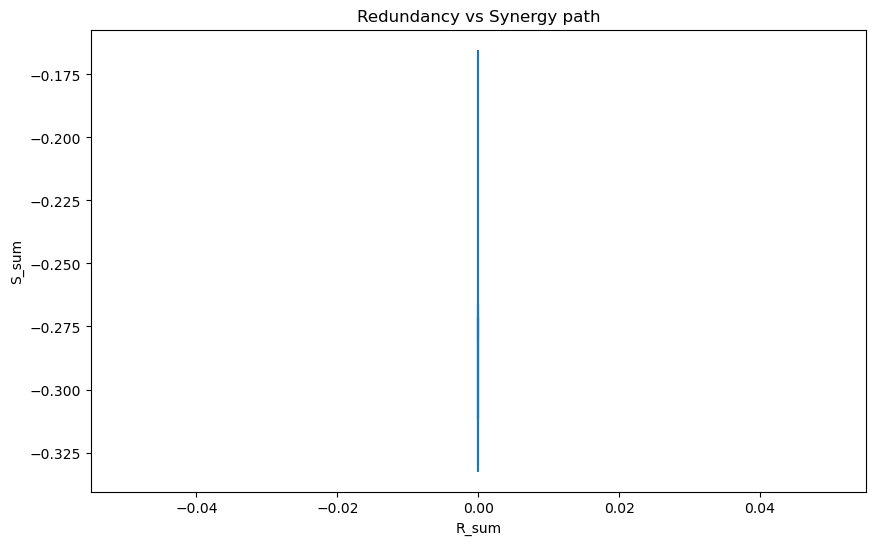

In [293]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(df['R_sum'], df['S_sum'])
plt.xlabel('R_sum')
plt.ylabel('S_sum')
plt.title('Redundancy vs Synergy path')
plt.show()

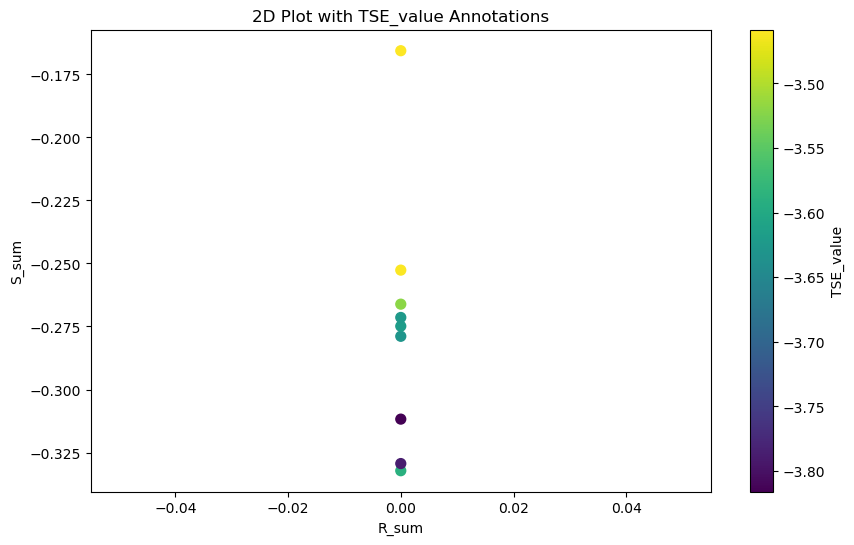

In [283]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(df['R_sum'], df['S_sum'], c=df['TSE_value'], cmap='viridis', s=50)

# Add labels for TSE_value at each point
#for i in range(len(df)):
#    plt.text(df['R_sum'].iloc[i], df['S_sum'].iloc[i], f'{df["TSE_value"].iloc[i]:.2f}',
#             fontsize=8, ha='center', va='center')

# Set labels and title
plt.xlabel('R_sum')
plt.ylabel('S_sum')
plt.title('2D Plot with TSE_value Annotations')

# Display colorbar based on TSE_value
plt.colorbar(label='TSE_value')

# Show the plot
plt.show()
